In [ ]:
# Installation cell
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.5/julia-1.5.3-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

In [ ]:
using Pkg
Pkg.add(PackageSpec(url="https://github.com/AxelvL/AHPQ.jl", rev="master"))
using AHPQ

In [ ]:
Pkg.add("HTTP")
using HTTP
Pkg.add("HDF5")
using HDF5
Pkg.add("Statistics")
using Statistics: norm
Pkg.add("Plots")
using Plots

## Downloading GloVe

In [ ]:
dir = HTTP.download("http://ann-benchmarks.com/glove-100-angular.hdf5", update_period=60)

data = h5open(dir, "r") do file
    read(file);
end

In [4]:
train       = data["train"]
queries     = data["test"]
groundtruth = data["neighbors"].+1;   #zero-indexed
train  = train ./ mapslices(norm, train, dims=1);
train_backup = deepcopy(train);

### 100 Bits Graph

In [5]:
n_codebooks = 25
n_centers = 16
n_neighbors = 100
stopcond=1e-1;

#### L2 loss

In [ ]:
ahpq = builder(train; 
                    T=0,
                    n_codebooks=n_codebooks, 
                    n_centers=n_centers,
                    verbose=true,
                    stopcond=stopcond,
                    a=0,
                    inverted_index=true,
                    multithreading=false,
                    training_points=25_000,
                    increment_steps=3);

In [ ]:
yhat_L2_100bits = MIPS(ahpq, queries, n_neighbors)
L2_scores_1  = get1atNscores(yhat_L2_100bits, groundtruth, n_neighbors)

#### Anisotropic Loss

In [ ]:
train = deepcopy(train_backup)
ahpq = builder(train; 
                    T=0.2,
                    n_codebooks=n_codebooks, 
                    n_centers=n_centers,
                    verbose=true,
                    stopcond=stopcond,
                    a=0,
                    inverted_index=false,
                    multithreading=true,
                    training_points=250_000,
                    increment_steps=3);

In [9]:
yhat_anisotropic_100bits = MIPS(ahpq, queries, n_neighbors)
anisotropic_scores_1  = get1atNscores(yhat_anisotropic_100bits, groundtruth, n_neighbors);

#### Comparison

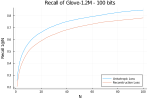

In [10]:
plot(1:100, anisotropic_scores_1, label="Anisotropic Loss")
plot!(1:100, L2_scores_1, label="Reconstruction Loss")
plot!(title="Recall of Glove-1.2M - 100 bits", 
      xlabel="N",
      ylabel="Recall 1@N",
      legend=:bottomright,
      xticks=0:20:100,
      yticks=0.1:0.1:0.9)

### 200 Bits Graph

In [11]:
n_codebooks = 50
n_centers = 16
n_neighbors = 100
stopcond=1e-1;

#### L2 loss

In [ ]:
train = deepcopy(train_backup)
ahpq = builder(train; 
                    T=0,
                    n_codebooks=n_codebooks, 
                    n_centers=n_centers,
                    verbose=true,
                    stopcond=stopcond,
                    a=0,
                    inverted_index=true,
                    multithreading=false,
                    training_points=250_000,
                    increment_steps=3);

In [ ]:
yhat_L2_200bits = MIPS(ahpq, queries, n_neighbors)
L2_scores_2  = get1atNscores(yhat_L2_200bits, groundtruth, n_neighbors);

#### Anisotropic Loss

In [ ]:
train = deepcopy(train_backup)
ahpq = builder(train; 
                    T=0.2,
                    n_codebooks=n_codebooks, 
                    n_centers=n_centers,
                    verbose=true,
                    stopcond=stopcond,
                    a=0,
                    inverted_index=true,
                    multithreading=false,
                    training_points=250_000,
                    increment_steps=3);

In [ ]:
yhat_anisotropic_200bits = MIPS(ahpq, queries, n_neighbors)
anisotropic_scores_2  = get1atNscores(yhat_anisotropic_200bits, groundtruth, n_neighbors)

#### Comparison

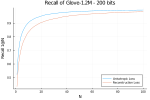

In [16]:
plot(1:100, anisotropic_scores_2, label="Anisotropic Loss")
plot!(1:100, L2_scores_2, label="Reconstruction Loss")
plot!(title="Recall of Glove-1.2M - 200 bits", 
      xlabel="N",
      ylabel="Recall 1@N",
      legend=:bottomright,
      xticks=0:20:100,
      yticks=0.1:0.1:0.9)